Other plots
====
That I would like to keep but don't fit anywhere else

In [1]:
from ema import clean

/home/mh19137/seaco_malaysia/ema/util.py:47: UserWarning: Not all dates are in 2022: set(dates.year.unique())={2021, 2022} 
  warnings.warn(f"Not all dates are in 2022: {set(dates.year.unique())=} ")
/home/mh19137/seaco_malaysia/ema/util.py:49: UserWarning: Dates are not a datetime series: type(dates)=<class 'pandas.core.series.Series'>
  warnings.warn(f"Dates are not a datetime series: {type(dates)=}")
/home/mh19137/seaco_malaysia/ema/util.py:49: UserWarning: Dates are not a datetime series: type(dates)=<class 'pandas.core.series.Series'>
  warnings.warn(f"Dates are not a datetime series: {type(dates)=}")


[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60.]
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47. 48. 49. 50. 51. 52. 53.
 54. 55. 56. 57. 58. 59. 60.]


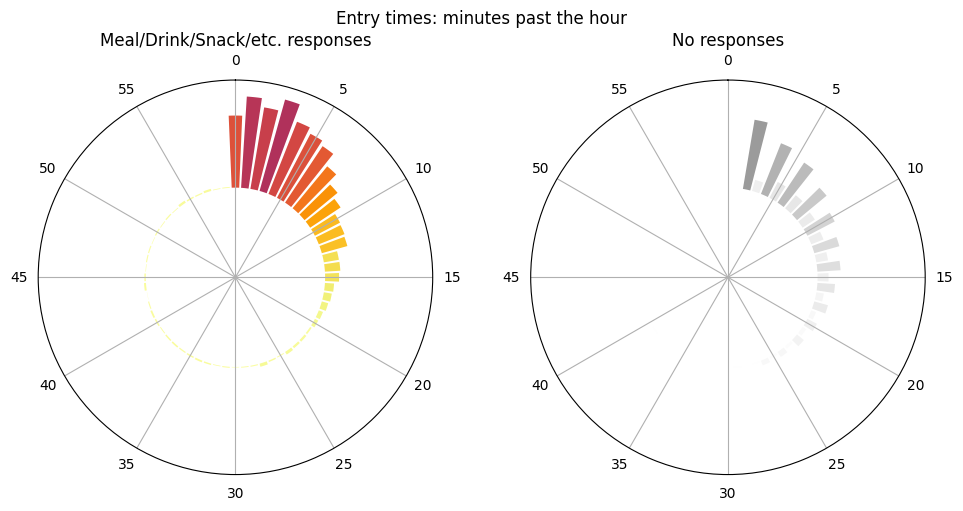

In [2]:
"""
Circular histogram of entries in minutes past the hour

"""
import numpy as np
import matplotlib.pyplot as plt

meal_info = clean.cleaned_smartwatch(remove_catchups=True)

no_responses = meal_info["meal_type"] == "No response"

fig, axes = plt.subplots(1, 2, subplot_kw={"projection": "polar"}, figsize=(10, 5))


def polar_hist(axis, meal_df, cmap, **kw):
    bins = np.linspace(0, 60, 61)
    radii, _ = np.histogram(meal_df.index.minute, bins=bins)
    print(bins)

    theta = np.linspace(0.0, 2 * np.pi, len(bins) - 1, endpoint=False)
    width = 0.8 * (2 * np.pi) / (len(bins) - 1)

    bars = axis.bar(theta, radii, width=width, bottom=1500, **kw)

    for r, bar in zip(radii, bars):
        bar.set_facecolor(cmap(r / 1000))


polar_hist(axes[0], meal_info[~no_responses], plt.cm.inferno_r)
polar_hist(axes[1], meal_info[no_responses], plt.cm.binary)

for axis in axes:
    n_ticks = 12
    axis.set_xticks(
        [2 * i * np.pi / n_ticks for i in range(n_ticks)],
        [int(i * 60 / n_ticks) for i in range(n_ticks)],
    )

    axis.set_theta_zero_location("N")
    axis.set_theta_direction(-1)

    axis.set_yticks([])

    axis.set_ylim(1000, 2100)

fig.suptitle("Entry times: minutes past the hour")
axes[0].set_title("Meal/Drink/Snack/etc. responses")
axes[1].set_title("No responses")

fig.tight_layout()
fig.savefig("img/clock_hist.png")

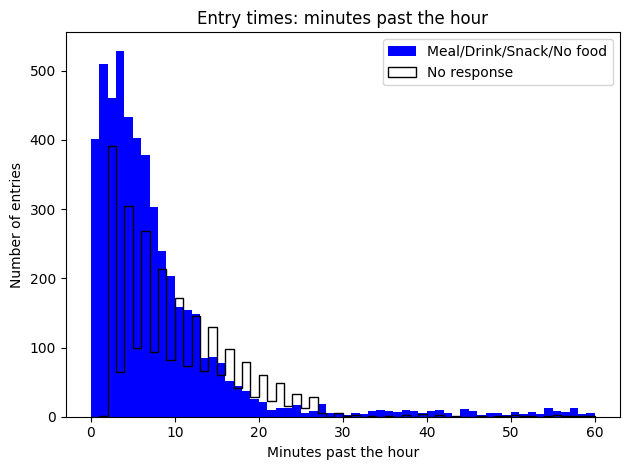

In [3]:
hist_kw = {"bins": np.linspace(0, 60, 61)}

plt.hist(
    meal_info.index.minute[~no_responses],
    **hist_kw,
    color="b",
    label="Meal/Drink/Snack/No food",
    histtype="stepfilled"
)
plt.hist(
    meal_info.index.minute[no_responses],
    **hist_kw,
    color="k",
    label="No response",
    histtype="step"
)

plt.xlabel("Minutes past the hour")
plt.ylabel("Number of entries")
plt.legend()
plt.title("Entry times: minutes past the hour")
plt.tight_layout()
plt.savefig("img/minutes_hist.png")